In [40]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, 
    unix_timestamp, 
    hour, 
    dayofweek,
    when,
    avg,
    round,
    date_format
)
from pyspark.sql import Row
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from meteostat import Point, Hourly

### Data source

#### taxi data
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

### Download Data

yellow_taxi_tripdata(2025.1 / 2025.2 / 2025.3)

In [ ]:
!mkdir -p ../data/nyc_taxi
!curl -L https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-01.parquet \
     -o ../data/nyc_taxi/yellow_tripdata_2025-01.parquet
!curl -L https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet \
     -o ../data/nyc_taxi/yellow_tripdata_2025-02.parquet
!curl -L https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2025-02.parquet \
     -o ../data/nyc_taxi/yellow_tripdata_2025-03.parquet 

### Data Ingestion

In [ ]:
spark = SparkSession.builder \
    .master("spark://spark-master:7077") \
    .appName("NYC_Taxi_Ingestion") \
    .getOrCreate()

In [6]:
taxi_df = spark.read.parquet(
    "file:///opt/spark/data/nyc_taxi/"
)
print(f"정제 전 데이터 개수: {taxi_df.count()}")
taxi_df.printSchema()

정제 전 데이터 개수: 8894676
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



 ### Data Cleaning and Transformation

In [7]:
# 1. Handle missing values
# 주요 컬럼(승차/하차 시간, 거리)이 없는 행은 삭제
df_cleaned = taxi_df.na.drop(
    subset=[
        "tpep_pickup_datetime", 
        "tpep_dropoff_datetime", 
        "trip_distance"
    ]
)

In [8]:
# 2. Filter out records with non-sensical values
# - 거리(Trip Distance)가 0보다 커야 함
# - 주행 시간이 0보다 커야 함
df_cleaned = df_cleaned.withColumn(
    "duration_seconds", 
    (unix_timestamp("tpep_dropoff_datetime")-unix_timestamp("tpep_pickup_datetime"))
).filter(
    (col("trip_distance") > 0) & 
    (col("duration_seconds") > 0) &
    (col("fare_amount") > 0)
)

In [9]:
# 3. Convert all relevant time fields to a standard timestamp format
df_cleaned = df_cleaned \
    .withColumn("pickup_hour", hour("tpep_pickup_datetime")) \
    .withColumn("pickup_day", dayofweek("tpep_pickup_datetime"))

print(f"정제 후 남은 데이터 개수: {df_cleaned.count()}")

정제 후 남은 데이터 개수: 8698877


### Metrics Calculation

In [10]:
# Show Average Trip duration & Average Trip distance
metrics = df_cleaned.select(
    (col("duration_seconds") / 60).alias("duration_minutes"),
    "trip_distance"
).agg(
    round(avg("duration_minutes"), 2).alias("Avg_Trip_Duration(minute)"),
    round(avg("trip_distance"), 2).alias("Avg_Trip_Distance(mile)")
)

print("### NYC Taxi Metrics Analysis ###")
metrics.show()

### NYC Taxi Metrics Analysis ###
+-------------------------+-----------------------+
|Avg_Trip_Duration(minute)|Avg_Trip_Distance(mile)|
+-------------------------+-----------------------+
|                     16.0|                   3.91|
+-------------------------+-----------------------+



### Peak Hours Analysis

In [13]:
peak_hours = df_cleaned.groupBy("pickup_hour") \
    .count() \
    .orderBy("count", ascending=False)

print("### Top 5 Peak Hours ###")
peak_hours.show(5)

### Top 5 Peak Hours ###
+-----------+------+
|pickup_hour| count|
+-----------+------+
|         18|622231|
|         17|597460|
|         19|554401|
|         16|553591|
|         15|549888|
+-----------+------+
only showing top 5 rows


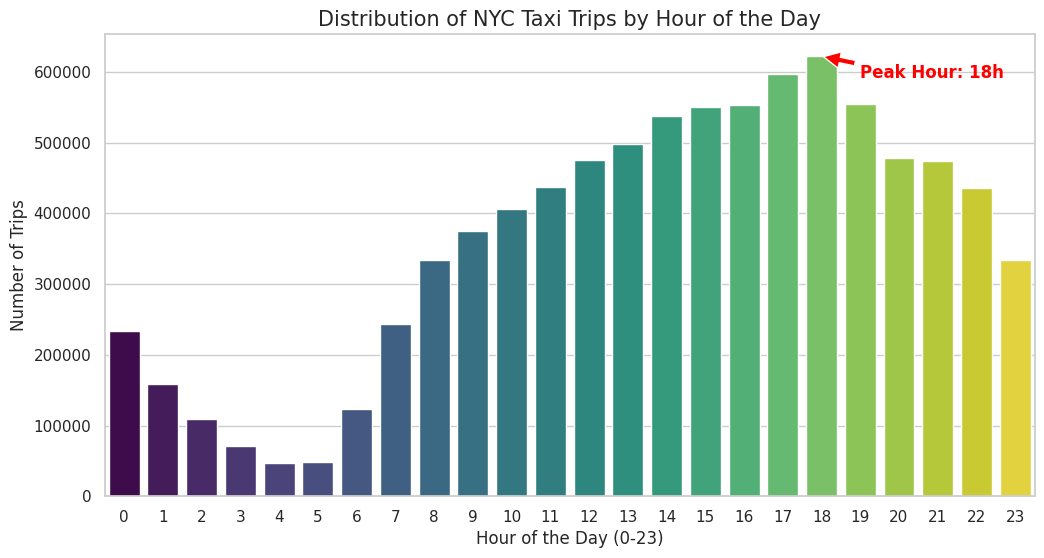

In [12]:
pdf_peak_hours = peak_hours \
    .toPandas().sort_values("pickup_hour")


sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

barplot = sns.barplot(
    x="pickup_hour", 
    y="count", 
    data=pdf_peak_hours, 
    hue="pickup_hour",  
    palette="viridis",
    legend=False       
)

max_row = pdf_peak_hours.loc[pdf_peak_hours['count'].idxmax()]
plt.annotate(
    f'Peak Hour: {int(max_row["pickup_hour"])}h', 
    xy=(max_row["pickup_hour"], max_row["count"]),
    xytext=(max_row["pickup_hour"]+1, max_row["count"]*0.95),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=12, 
    color='red', 
    fontweight='bold'
)

plt.title("Distribution of NYC Taxi Trips by Hour of the Day", fontsize=15)
plt.xlabel("Hour of the Day (0-23)", fontsize=12)
plt.ylabel("Number of Trips", fontsize=12)
plt.xticks(range(0, 24))

plt.show()


### Weather Condition Analysis

#### Get Weather data

In [16]:
# Set coordinates and time period
location = Point(40.7812, -73.9665)
start = datetime(2025, 1, 1)
end = datetime(2025, 3, 31)

# Fetch hourly data
data = Hourly(location, start, end)
data = data.fetch()

#Pandas -> Spark DataFrame
weather_df = spark.createDataFrame(data.reset_index())
weather_df.printSchema()

root
 |-- time: timestamp (nullable = true)
 |-- temp: double (nullable = true)
 |-- dwpt: double (nullable = true)
 |-- rhum: double (nullable = true)
 |-- prcp: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- wdir: double (nullable = true)
 |-- wspd: double (nullable = true)
 |-- wpgt: double (nullable = true)
 |-- pres: double (nullable = true)
 |-- tsun: double (nullable = true)
 |-- coco: double (nullable = true)



In [35]:
# 1. Preprocess weather data (Selected columns: time, temp, prcp)
weather_processed = weather_df.select(
    date_format(col("time"), "yyyy-MM-dd HH").alias("weather_join_time"),
    col("temp").alias("temperature"),
    col("prcp").alias("precipitation")
)

# 2. Aggregate taxi data by hour (Calculate demand)
taxi_hourly_demand = df_cleaned.withColumn(
    "taxi_join_time", date_format("tpep_pickup_datetime", "yyyy-MM-dd HH")
).groupBy("taxi_join_time").count().withColumnRenamed("count", "trip_count")

# 3. Join
analysis_df = taxi_hourly_demand.join(
    weather_processed,
    taxi_hourly_demand.taxi_join_time == weather_processed.weather_join_time,
    "inner"
).select("trip_count", "temperature", "precipitation")

analysis_df.show(5)

+----------+-----------+-------------+
|trip_count|temperature|precipitation|
+----------+-----------+-------------+
|     14290|       -4.0|          0.0|
|       750|        9.0|          0.0|
|      1934|        2.0|          0.0|
|      9026|        2.0|          0.0|
|      1810|        2.0|          0.3|
+----------+-----------+-------------+
only showing top 5 rows


In [36]:
corr_temp = analysis_df.stat.corr("trip_count", "temperature")
corr_prcp = analysis_df.stat.corr("trip_count", "precipitation")

print(f"Correlation (Trips vs Temperature): {corr_temp:.4f}")
print(f"Correlation (Trips vs Precipitation): {corr_prcp:.4f}")

Correlation (Trips vs Temperature): 0.1537
Correlation (Trips vs Precipitation): 0.0063


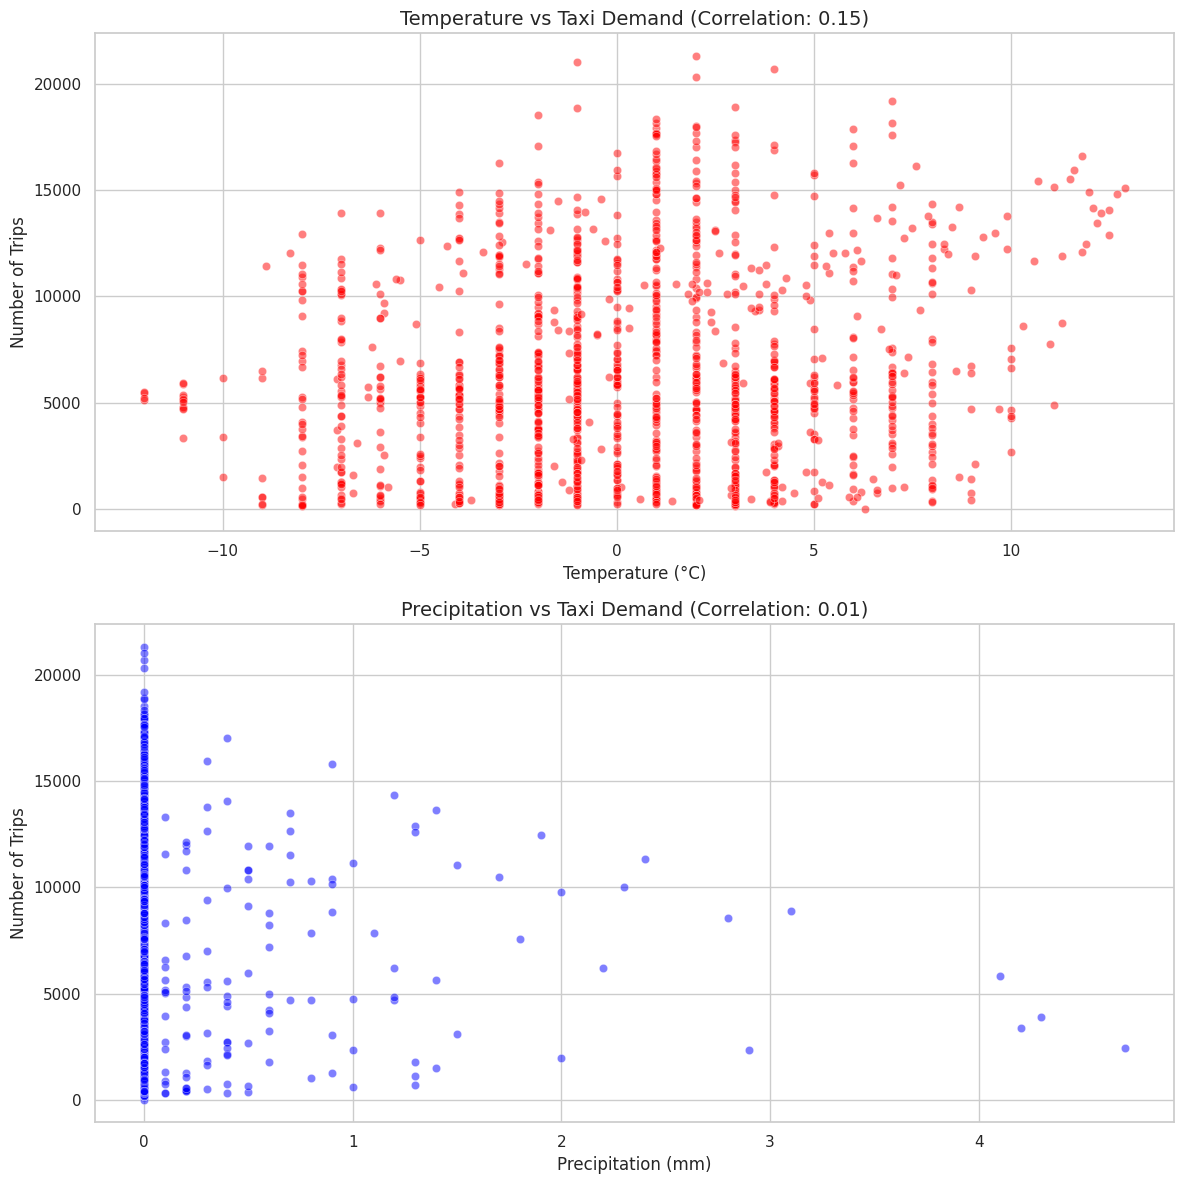

In [38]:
pdf_analysis = analysis_df.toPandas()

sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 1. 기온과 수요의 관계
sns.scatterplot(
    x='temperature', 
    y='trip_count', 
    data=pdf_analysis, 
    ax=ax1, 
    alpha=0.5, 
    color='red'
)
ax1.set_title(f"Temperature vs Taxi Demand (Correlation: {corr_temp:.2f})", fontsize=14)
ax1.set_xlabel("Temperature (°C)")
ax1.set_ylabel("Number of Trips")

# 2. 강수량과 수요의 관계
sns.scatterplot(
    x='precipitation', 
    y='trip_count', 
    data=pdf_analysis, 
    ax=ax2, 
    alpha=0.5, 
    color='blue'
)
ax2.set_title(f"Precipitation vs Taxi Demand (Correlation: {corr_prcp:.2f})", fontsize=14)
ax2.set_xlabel("Precipitation (mm)")
ax2.set_ylabel("Number of Trips")

plt.tight_layout()
plt.show()

### Save result

In [44]:
final_metrics = [
    Row(category="Correlation", metric="Trips_vs_Temp", value=float(corr_temp)),
    Row(category="Correlation", metric="Trips_vs_Precip", value=float(corr_prcp)),
    Row(category="Trip_Stats", metric="Avg_Trip_Distance(mile)", value=float(metrics.collect()[0]['Avg_Trip_Distance(mile)'])),
    Row(category="Trip_Stats", metric="Avg_Trip_Duration(minute)", value=float(metrics.collect()[0]['Avg_Trip_Duration(minute)']))
]

final_summary_df = spark.createDataFrame(final_metrics)
final_summary_df.coalesce(1) \
    .write.mode("overwrite").option("header", "true") \
    .csv("/opt/spark/data/output/final_summary_report")



final_summary_df.show()
print("결과가 /opt/spark/data/output/ 에 저장되었습니다.")

+-----------+--------------------+--------------------+
|   category|              metric|               value|
+-----------+--------------------+--------------------+
|Correlation|       Trips_vs_Temp|  0.1537169977287415|
|Correlation|     Trips_vs_Precip|0.006316561196085408|
| Trip_Stats|Avg_Trip_Distance...|                4.44|
| Trip_Stats|Avg_Trip_Duration...|               15.35|
+-----------+--------------------+--------------------+

결과가 /opt/spark/data/output/ 에 저장되었습니다.
